### Setup of a two-qubit chip with $C^3$

In this example we will set-up a two qubit quantum processor and define a simple gate.

#### Imports

In [1]:
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from pprint import pprint

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils

# Qiskit related modules
from c3.qiskit import C3Provider
from c3.qiskit.c3_gates import RX90pGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram

#### Model components
We first create a qubit. Each parameter is a Quantity (`Qty()`) object with bounds and a unit. In $C^3$, the default multi-level qubit is a Transmon modelled as a Duffing oscillator with frequency $\omega$ and anharmonicity $\delta$ :
$$ H/\hbar = \omega b^\dagger b - \frac{\delta}{2}                        \left(b^\dagger b - 1\right) b^\dagger b 
$$
The "name" will be used to identify this qubit (or other component) later and should thus be chosen carefully.

In [2]:
qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(
        value=freq_q1,
        min_val=4.995e9 ,
        max_val=5.005e9 ,
        unit='Hz 2pi'
    ),
    anhar=Qty(
        value=anhar_q1,
        min_val=-380e6 ,
        max_val=-120e6 ,
        unit='Hz 2pi'
    ),
    hilbert_dim=qubit_lvls,
    t1=Qty(
        value=t1_q1,
        min_val=1e-6,
        max_val=90e-6,
        unit='s'
    ),
    t2star=Qty(
        value=t2star_q1,
        min_val=10e-6,
        max_val=90e-3,
        unit='s'
    ),
    temp=Qty(
        value=qubit_temp,
        min_val=0.0,
        max_val=0.12,
        unit='K'
    )
)

In the same spirit, we specify control Hamiltonians to drive the system. Again "connected" connected tells us which qubit this drive acts on and "name" will later be used to assign the correct control signal to this drive line.

In [3]:
drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)

#### SPAM errors
In experimental practice, the qubit state can be mis-classified during read-out. We simulate this by constructing a _confusion matrix_, containing the probabilities for one qubit state being mistaken for another.

In [4]:
m00_q1 = 0.97  # Prop to read qubit 1 state 0 as 0
m01_q1 = 0.04  # Prop to read qubit 1 state 0 as 1
m00_q2 = 0.96  # Prop to read qubit 2 state 0 as 0
m01_q2 = 0.05  # Prop to read qubit 2 state 0 as 1
one_zeros = np.array([0] * qubit_lvls)
zero_ones = np.array([1] * qubit_lvls)
one_zeros[0] = 1
zero_ones[0] = 0
val1 = one_zeros * m00_q1 + zero_ones * m01_q1
val2 = one_zeros * m00_q2 + zero_ones * m01_q2
min_val = one_zeros * 0.8 + zero_ones * 0.0
max_val = one_zeros * 1.0 + zero_ones * 0.2
confusion_row1 = Qty(value=val1, min_val=min_val, max_val=max_val, unit="")
confusion_row2 = Qty(value=val2, min_val=min_val, max_val=max_val, unit="")
conf_matrix = tasks.ConfusionMatrix(Q1=confusion_row1, Q2=confusion_row2)

The following task creates an initial thermal state with given temperature.

In [5]:
init_temp = 50e-3
init_ground = tasks.InitialiseGround(
    init_temp=Qty(
        value=init_temp,
        min_val=-0.001,
        max_val=0.22,
        unit='K'
    )
)

We collect the parts specified above in the Model.

In [6]:
model = Mdl(
    [q1], # Individual, self-contained components
    [drive],  # Interactions between components
    # [conf_matrix, init_ground] # SPAM processing
)

Further, we can decide between coherent or open-system dynamics using set_lindbladian() and whether to eliminate the static coupling by going to the dressed frame with set_dressed().

In [7]:
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals
With the model taken care of, we now specify the control electronics and signal chain. Complex shaped controls are often realized by creating an envelope signal with an arbitrary waveform generator (AWG) with limited bandwith and mixing it with a fast, stable local oscillator (LO).

In [8]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG
lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')

In simulation, we translate between AWG resolution and simulation (or "analog") resolultion by including an up-sampling device.

In [9]:

dig_to_an = devices.DigitalToAnalog(
    name="dac",
    resolution=sim_res
)

Control electronics apply voltages to lines, whereas in a Hamiltonian we usually write the control fields in energy or frequency units. In practice, this conversion can be highly non-trivial if it involves multiple stages of attenuation and for example the conversion of a line voltage in an antenna to a dipole field coupling to the qubit. The following device represents a simple, linear conversion factor.

In [10]:
v2hz = 1e9
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(
        value=v2hz,
        min_val=0.9e9,
        max_val=1.1e9,
        unit='Hz/V'
    )
)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [11]:
generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "d1": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            },
            "d2": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            },
        }
    )

Optionally, we can look at the signal generated by each device by setting a callback.

In [12]:
generator.callback = lambda chain_id, device_id, signal: (
    # do something
)

#### Gates-set and Parameter map
It remains to write down what kind of operations we want to perform on the device. For a gate based quantum computing chip, we define a gate-set.

We choose a gate time of 7ns and a gaussian envelope shape with a list of parameters.

In [13]:
t_final = 7e-9   # Time for single qubit gates
sideband = 50e6 
gauss_params_single = {
    'amp': Qty(
        value=0.3,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

In [14]:
gauss1_params_single = {
    'amp': Qty(
        value=0.28,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}


gauss2_params_single = {
    'amp': Qty(
        value=0.26,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}


gauss3_params_single = {
    'amp': Qty(
        value=0.24,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}


gauss4_params_single = {
    'amp': Qty(
        value=0.22,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}


gauss5_params_single = {
    'amp': Qty(
        value=0.2,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}


gauss6_params_single = {
    'amp': Qty(
        value=0.18,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}


gauss7_params_single = {
    'amp': Qty(
        value=0.16,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

gauss8_params_single = {
    'amp': Qty(
        value=0.2,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

Here we take `gaussian_nonorm()` from the libraries as the function to define the shape.

In [15]:
gauss_env_single = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

gauss_env_single1 = pulse.Envelope(
    name="gauss2",
    desc="Gaussian sigma comp for single-qubit gates",
    params=gauss1_params_single,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

gauss_env_single2 = pulse.Envelope(
    name="gauss3",
    desc="Hann comp for single-qubit gates",
    params=gauss2_params_single,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

gauss_env_single3 = pulse.Envelope(
    name="gauss4",
    desc="Hamming comp for single-qubit gates",
    params=gauss3_params_single,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

# gauss_env_single4 = pulse.Envelope(
#     name="gauss_der",
#     desc="Gauss_der comp for single-qubit gates",
#     params=gauss4_params_single,
#     shape=envelopes.gaussian_der_nonorm,
#     normalize_pulse=True
# )

gauss_env_single5 = pulse.Envelope(
    name="gauss5",
    desc="Second Gaussian comp for single-qubit gates",
    params=gauss5_params_single,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

gauss_env_single6 = pulse.Envelope(
    name="gauss6",
    desc="Third Gaussian comp for single-qubit gates",
    params=gauss6_params_single,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

gauss_env_single7 = pulse.Envelope(
    name="gauss7",
    desc="Second gaussian sigma comp for single-qubit gates",
    params=gauss7_params_single,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

gauss_env_single8 = pulse.Envelope(
    name="gauss8",
    desc="Second hamming comp for single-qubit gates",
    params=gauss8_params_single,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

# cosineflattop_env_single = pulse.Envelope(
#     name="cosine_flattop",
#     desc="Cosine flat top comp for single-qubit gates",
#     params=cosineflattop_params_single,
#     shape=envelopes.cosine_flattop,
#     normalize_pulse=True
# )

We specify the drive tones with an offset from the qubit frequencies. As is done in experiment, we will later adjust the resonance by modulating the envelope function.

In [16]:
lo_freq_q1 = 5e9  + sideband
carrier_parameters = {
    'freq': Qty(
        value=lo_freq_q1,
        min_val=4.5e9 ,
        max_val=6e9 ,
        unit='Hz 2pi'
    ),
    'framechange': Qty(
        value=0.0,
        min_val= -np.pi,
        max_val= 3 * np.pi,
        unit='rad'
    )
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters
)

For the second qubit drive tone, we copy the first one and replace the frequency. The deepcopy is to ensure that we don't just create a pointer to the first drive.

In [17]:
lo_freq_q2 = 5.6e9  + sideband
carr_2 = copy.deepcopy(carr)
carr_2.params['freq'].set_value(lo_freq_q2)

#### Instructions
We define the gates we want to perform with a "name" that will identify them later and "channels" relating to the control Hamiltonians and drive lines we specified earlier. As a start we write down 90 degree rotations in the positive $x$-direction and identity gates for both qubits. Then we add a carrier and envelope to each.

In [18]:
rx90p_q1 = gates.Instruction(
    name="rx90p", targets=[0], t_start=0.0, t_end=t_final, channels=["d1"]
)

rx90p_q1.add_component(gauss_env_single, "d1")
rx90p_q1.add_component(carr, "d1")

rx90p_q1.add_component(gauss_env_single1, "d1")

rx90p_q1.add_component(gauss_env_single2, "d1")

rx90p_q1.add_component(gauss_env_single3, "d1")

# rx90p_q1.add_component(gauss_env_single4, "d1")  # Don't use

rx90p_q1.add_component(gauss_env_single5, "d1")

rx90p_q1.add_component(gauss_env_single6, "d1")

rx90p_q1.add_component(gauss_env_single7, "d1")

rx90p_q1.add_component(gauss_env_single8, "d1")

# rx90p_q1.add_component(cosineflattop_env_single, "d1")

When later compiling gates into sequences, we have to take care of the relative rotating frames of the qubits and local oscillators. We do this by adding a phase after each gate that realigns the frames.

In [19]:
# rx90p_q1.add_component(nodrive_env, "d2")
# rx90p_q1.add_component(copy.deepcopy(carr_2), "d2")
# rx90p_q1.comps["d2"]["carrier"].params["framechange"].set_value(
#     (-sideband * t_final) * 2 * np.pi % (2 * np.pi)
# )

# rx90p_q2.add_component(nodrive_env, "d1")
# rx90p_q2.add_component(copy.deepcopy(carr), "d1")
# rx90p_q2.comps["d1"]["carrier"].params["framechange"].set_value(
#     (-sideband * t_final) * 2 * np.pi % (2 * np.pi)
# )

In [20]:
######### Plot the control signals #############

def plot_controls(pmap, prefactor):
    for gate, instruction in pmap.instructions.items():
        fig, ax = plt.subplots(1)
        ax.set_title(gate.replace("_", "-"))
        legend = []
        counter = 0
        for chan, channel in instruction.comps.items():
            amp = prefactor[counter]
            counter += 1
            for com, component in channel.items():
                if "t_final" in component.params:
                    t_final = component.params["t_final"].get_value()
                    ts = np.linspace(0, t_final, 1001)
                    shape = amp * component.get_shape_values(ts)
                    ax.plot(ts[:len(shape)]/1e-9, shape)
                    legend.append((chan, com.replace("_", "-")))
        ax.set_xlabel("Time [ns]")
#         ax.set_ylabel("Amplitude")
        ax.set_ylabel("Amplitude [normalized]")
        ax.legend(legend)

In [21]:
# def find_l1(pmap):
#     for gate, instruction in pmap.instructions.items():
#         l1_norm = 0
#         for chan, channel in instruction.comps.items():
# #             print(chan)
# #             print(channel)
#             for com, component in channel.items():
# #                 print(com)
# #                 print(component)
#                 if "amp" in component.params:
#                     amplitude = component.params["amp"].get_value()
#                     l1_norm += tf.math.abs(amplitude)
# #             print(f"L1 norm for control signals in channel: {channel}, is {l1_norm}")

The remainder of the gates-set can be derived from the RX90p gate by shifting its phase by multiples of $\pi/2$.

In [22]:
# ry90p_q1 = copy.deepcopy(rx90p_q1)
# ry90p_q1.name = "ry90p"
# rx90m_q1 = copy.deepcopy(rx90p_q1)
# rx90m_q1.name = "rx90m"
# ry90m_q1 = copy.deepcopy(rx90p_q1)
# ry90m_q1.name = "ry90m"
# ry90p_q1.comps['d1']['gauss'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q1.comps['d1']['gauss'].params['xy_angle'].set_value(np.pi)
# ry90m_q1.comps['d1']['gauss'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q1.comps['d1']['gauss_sigma'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q1.comps['d1']['gauss_sigma'].params['xy_angle'].set_value(np.pi)
# ry90m_q1.comps['d1']['gauss_sigma'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q1.comps['d1']['hann'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q1.comps['d1']['hann'].params['xy_angle'].set_value(np.pi)
# ry90m_q1.comps['d1']['hann'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q1.comps['d1']['hamming'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q1.comps['d1']['hamming'].params['xy_angle'].set_value(np.pi)
# ry90m_q1.comps['d1']['hamming'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q1.comps['d1']['gauss_der'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q1.comps['d1']['gauss_der'].params['xy_angle'].set_value(np.pi)
# ry90m_q1.comps['d1']['gauss_der'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q1.comps['d1']['gauss2'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q1.comps['d1']['gauss2'].params['xy_angle'].set_value(np.pi)
# ry90m_q1.comps['d1']['gauss2'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q1.comps['d1']['cosine_flattop'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q1.comps['d1']['cosine_flattop'].params['xy_angle'].set_value(np.pi)
# ry90m_q1.comps['d1']['cosine_flattop'].params['xy_angle'].set_value(1.5 * np.pi)
# single_q_gates = [rx90p_q1, ry90p_q1, rx90m_q1, ry90m_q1]
single_q_gates = [rx90p_q1]

# ry90p_q2 = copy.deepcopy(rx90p_q2)
# ry90p_q2.name = "ry90p"
# rx90m_q2 = copy.deepcopy(rx90p_q2)
# rx90m_q2.name = "rx90m"
# ry90m_q2 = copy.deepcopy(rx90p_q2)
# ry90m_q2.name = "ry90m"
# ry90p_q2.comps['d2']['gauss'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q2.comps['d2']['gauss'].params['xy_angle'].set_value(np.pi)
# ry90m_q2.comps['d2']['gauss'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q2.comps['d2']['gauss_sigma'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q2.comps['d2']['gauss_sigma'].params['xy_angle'].set_value(np.pi)
# ry90m_q2.comps['d2']['gauss_sigma'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q2.comps['d2']['hann'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q2.comps['d2']['hann'].params['xy_angle'].set_value(np.pi)
# ry90m_q2.comps['d2']['hann'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q2.comps['d2']['hamming'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q2.comps['d2']['hamming'].params['xy_angle'].set_value(np.pi)
# ry90m_q2.comps['d2']['hamming'].params['xy_angle'].set_value(1.5 * np.pi)

# # ry90p_q2.comps['d2']['gauss_der'].params['xy_angle'].set_value(0.5 * np.pi)
# # rx90m_q2.comps['d2']['gauss_der'].params['xy_angle'].set_value(np.pi)
# # ry90m_q2.comps['d2']['gauss_der'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q2.comps['d2']['gauss2'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q2.comps['d2']['gauss2'].params['xy_angle'].set_value(np.pi)
# ry90m_q2.comps['d2']['gauss2'].params['xy_angle'].set_value(1.5 * np.pi)

# ry90p_q2.comps['d2']['cosine_flattop'].params['xy_angle'].set_value(0.5 * np.pi)
# rx90m_q2.comps['d2']['cosine_flattop'].params['xy_angle'].set_value(np.pi)
# ry90m_q2.comps['d2']['cosine_flattop'].params['xy_angle'].set_value(1.5 * np.pi)
# single_q_gates.extend([rx90p_q2, ry90p_q2, rx90m_q2, ry90m_q2])
# # single_q_gates = [rx90p_q2]

In [23]:
rx90p_q1.comps["d1"]

{'gauss': gauss:: amp : 300.000 mV , delta : -1.000  , freq_offset : -53.000 MHz 2pi , xy_angle : -444.089 arad , sigma : 1.750 ns , t_final : 7.000 ns , shape: gaussian_nonorm, drag pulseFalse, ,
 'carrier': carrier:: freq : 5.050 GHz 2pi , framechange : 0.000 rad , ,
 'gauss2': gauss2:: amp : 280.000 mV , delta : -1.000  , freq_offset : -53.000 MHz 2pi , xy_angle : -444.089 arad , sigma : 1.750 ns , t_final : 7.000 ns , shape: gaussian_nonorm, drag pulseFalse, ,
 'gauss3': gauss3:: amp : 260.000 mV , delta : -1.000  , freq_offset : -53.000 MHz 2pi , xy_angle : -444.089 arad , sigma : 1.750 ns , t_final : 7.000 ns , shape: gaussian_nonorm, drag pulseFalse, ,
 'gauss4': gauss4:: amp : 240.000 mV , delta : -1.000  , freq_offset : -53.000 MHz 2pi , xy_angle : -444.089 arad , sigma : 1.750 ns , t_final : 7.000 ns , shape: gaussian_nonorm, drag pulseFalse, ,
 'gauss5': gauss5:: amp : 200.000 mV , delta : -1.000  , freq_offset : -53.000 MHz 2pi , xy_angle : -444.089 arad , sigma : 1.750 ns 

With every component defined, we collect them in the parameter map, our object that holds information and methods to manipulate and examine model and control parameters.

In [24]:
parameter_map = PMap(instructions=single_q_gates, model=model, generator=generator)
# print(parameter_map)

In [25]:
# pre_factor = [0.1, 0.3, 0.1, 0.1, 0.3, 0.3, 0.3]

In [26]:
# plot_controls(parameter_map, pre_factor)

#### The experiment
Finally everything is collected in the experiment that provides the functions to interact with the system.

In [27]:
exp = Exp(pmap=parameter_map)

#### Simulation
With our experiment all set-up, we can perform simulations. We first decide which basic gates to simulate, in this case only the 90 degree rotation on one qubit and the identity.

In [28]:
exp.set_opt_gates(['rx90p[0]'])

The actual numerical simulation is done by calling `exp.compute_propagators()`. 
This is the most resource intensive part as it involves solving the equations of motion for the system.

In [29]:
unitaries = exp.compute_propagators()

After this step the unitaries or process matrices are stored in the exp object. We can look at their names and matrix representations.

In [30]:
unitaries

{'rx90p[0]': <tf.Tensor: shape=(3, 3), dtype=complex128, numpy=
 array([[ 0.6312664 +0.03508226j, -0.14293598-0.75568246j,
          0.09357836+0.00532644j],
        [-0.1439525 -0.75548741j,  0.57726924-0.26956251j,
         -0.03887392-0.03318972j],
        [ 0.09358085+0.00557176j, -0.03873026-0.03331018j,
         -0.97313432+0.20398917j]])>}

### Dynamics

To investigate dynamics, we define the ground state as an initial state.

In [31]:
psi_init = [[0] * 3]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

In [32]:
init_state

<tf.Tensor: shape=(3, 1), dtype=complex128, numpy=
array([[1.+0.j],
       [0.+0.j],
       [0.+0.j]])>

Since we stored the process matrices, we can now relatively inexpesively evaluate sequences. We start with just one gate

In [33]:
barely_a_seq = ['rx90p[0]']

and plot system dynamics.

In [34]:
def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

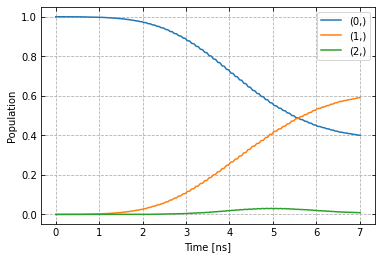

In [35]:
plot_dynamics(exp, init_state, barely_a_seq)

We can see an ill-defined un-optimized gate. The labels indicate qubit states in the product basis. Next we increase the number of repetitions of the same gate.

In [36]:
barely_a_seq * 10

['rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]']

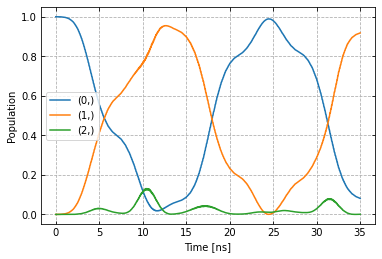

In [37]:
plot_dynamics(exp, init_state, barely_a_seq * 5)

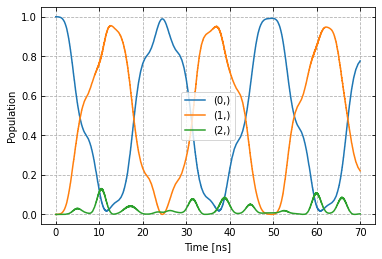

In [38]:
plot_dynamics(exp, init_state, barely_a_seq * 10)

Note that at this point, we only multiply already computed matrices. We don't need to solve the equations of motion again for new sequences.

#### Visualisation with qiskit circuit

In [39]:
qc = QuantumCircuit(1)
qc.append(RX90pGate(), [0])
qc.draw()

┌────────────┐
q: ┤ Rx90p(π/2) ├
   └────────────┘

In [40]:
c3_provider = C3Provider()
c3_backend = c3_provider.get_backend("c3_qasm_physics_simulator")
c3_backend.set_c3_experiment(exp)

In [41]:
c3_job_unopt = c3_backend.run(qc)
result_unopt = c3_job_unopt.result()
res_pops_unopt = result_unopt.data()["state_pops"]
print("Result from unoptimized gates:") 
pprint(res_pops_unopt)

No classical registers in circuit "circuit-0", counts will be empty.


Result from unoptimized gates:
{'(0,)': 0.39972803891809267,
 '(1,)': 0.591483541402466,
 '(2,)': 0.008788419679447646}


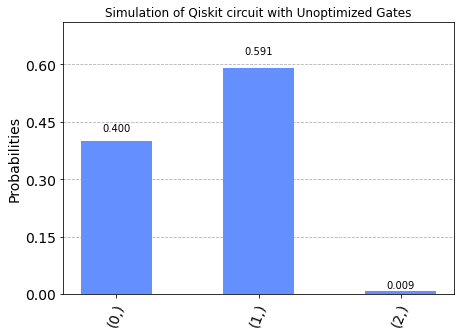

In [42]:
plot_histogram(res_pops_unopt, title='Simulation of Qiskit circuit with Unoptimized Gates')

#### Open-loop optimal control

In order to improve the gate, we create the optimizer object for open-loop optimal control. We notice some leakage into the $|2,0>$ state and enable a DRAG option. Details on DRAG can be found here: https://arxiv.org/abs/1809.04919 The main principle is adding a phase-shifted component proportional to the derivative of the original signal. With automatic differentiation, our AWG can perform this operation automatically for arbitrary shapes.

In [43]:
generator.devices['AWG'].enable_drag_2()

At the moment there are two implementations of DRAG, variant 2 is independent of the AWG resolution.

To define which parameters we optimize, we write the gateset_opt_map, a nested list of tuples that identifies each parameter.

In [44]:
# ############## With two gaussians ###################

# opt_gates = ["rx90p[0]"]
# gateset_opt_map=[
#     [
#       ("rx90p[0]", "d1", "gauss", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "carrier", "framechange"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "delta"),
#     ]
# ]
# parameter_map.set_opt_map(gateset_opt_map)

In [45]:
opt_gates = ["rx90p[0]"]
gateset_opt_map=[
    [
      ("rx90p[0]", "d1", "gauss", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "gauss", "freq_offset"),
    ],
    [
      ("rx90p[0]", "d1", "gauss", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "gauss", "delta"),
    ],
    [
      ("rx90p[0]", "d1", "carrier", "framechange"),
    ],
    [
      ("rx90p[0]", "d1", "gauss2", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "gauss2", "freq_offset"),
    ],
    [
      ("rx90p[0]", "d1", "gauss2", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "gauss2", "delta"),
    ],
    [
      ("rx90p[0]", "d1", "gauss3", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "gauss3", "freq_offset"),
    ],
    [
      ("rx90p[0]", "d1", "gauss3", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "gauss3", "delta"),
    ],
    [
      ("rx90p[0]", "d1", "gauss4", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "gauss4", "freq_offset"),
    ],
    [
      ("rx90p[0]", "d1", "gauss4", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "gauss4", "delta"),
    ],
    [
      ("rx90p[0]", "d1", "gauss5", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "gauss5", "freq_offset"),
    ],
    [
      ("rx90p[0]", "d1", "gauss5", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "gauss5", "delta"),
    ],
    [
      ("rx90p[0]", "d1", "gauss6", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "gauss6", "freq_offset"),
    ],
    [
      ("rx90p[0]", "d1", "gauss6", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "gauss6", "delta"),
    ],
    [
      ("rx90p[0]", "d1", "gauss7", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "gauss7", "freq_offset"),
    ],
    [
      ("rx90p[0]", "d1", "gauss7", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "gauss7", "delta"),
    ],
    [
      ("rx90p[0]", "d1", "gauss8", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "gauss8", "freq_offset"),
    ],
    [
      ("rx90p[0]", "d1", "gauss8", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "gauss8", "delta"),
    ]
]
parameter_map.set_opt_map(gateset_opt_map)

In [46]:
# ############## Test code for Shai's task #################

# opt_gates = ["rx90p[0]"]
# gateset_opt_map=[
#     [
#       ("rx90p[0]", "d1", "gauss", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "carrier", "framechange"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hann", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hann", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hann", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hann", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss3", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss3", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss3", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss3", "delta"),
#     ]
# ]
# parameter_map.set_opt_map(gateset_opt_map)

In [47]:
# ########### The one consisting gauss_der ################

# opt_gates = ["rx90p[0]"]
# gateset_opt_map=[
#     [
#       ("rx90p[0]", "d1", "gauss", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "carrier", "framechange"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_sigma", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_sigma", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_sigma", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_sigma", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hann", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hann", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hann", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hann", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hamming", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hamming", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hamming", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hamming", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_der", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_der", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_der", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_der", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss2", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss3", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss3", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss3", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss3", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_sigma2", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_sigma2", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_sigma2", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "gauss_sigma2", "delta"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hamming2", "amp"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hamming2", "freq_offset"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hamming2", "xy_angle"),
#     ],
#     [
#       ("rx90p[0]", "d1", "hamming2", "delta"),
#     ]
# ]
# parameter_map.set_opt_map(gateset_opt_map)

We can look at the parameters this opt_map specified with

In [48]:
parameter_map.print_parameters()

rx90p[0]-d1-gauss-amp                 : 300.000 mV 
rx90p[0]-d1-gauss-freq_offset         : -53.000 MHz 2pi 
rx90p[0]-d1-gauss-xy_angle            : -444.089 arad 
rx90p[0]-d1-gauss-delta               : -1.000  
rx90p[0]-d1-carrier-framechange       : 0.000 rad 
rx90p[0]-d1-gauss2-amp                : 280.000 mV 
rx90p[0]-d1-gauss2-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss2-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss2-delta              : -1.000  
rx90p[0]-d1-gauss3-amp                : 260.000 mV 
rx90p[0]-d1-gauss3-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss3-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss3-delta              : -1.000  
rx90p[0]-d1-gauss4-amp                : 240.000 mV 
rx90p[0]-d1-gauss4-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss4-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss4-delta              : -1.000  
rx90p[0]-d1-gauss5-amp                : 200.000 mV 
rx90p[0]-d1-gauss5-freq_offset        : -53.0

In [49]:
from c3.optimizers.optimalcontrol import OptimalControl

The OptimalControl object will handle the optimization for us. As a fidelity function we choose average fidelity as well as LBFG-S (a wrapper of the scipy implementation) from our library. See those libraries for how these functions are defined and how to supply your own, if necessary.

In [50]:
import os
import tempfile

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.sparse_unitary_infid_set,
    fid_subspace=["Q1"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun" : 150},
    run_name="better_X90"
)

Finally we supply our defined experiment.

In [51]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)

Everything is in place to start the optimization.

In [52]:
opt.optimize_controls()

C3:STATUS:Saving as: C:\Users\tsark\AppData\Local\Temp\tmp_yfknuu2\c3logs\better_X90\2022_05_24_T_13_37_39\open_loop.c3log


c:\users\tsark\onedrive\documents\c3\c3\utils\utils.py:64: UserWarning: OSError encountered while creating symlink
  warnings.warn("OSError encountered while creating symlink")
c:\users\tsark\onedrive\documents\c3\c3\optimizers\optimizer.py:293: Warning: rx90p[0]-d1-gauss7-freq_offset has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
c:\users\tsark\onedrive\documents\c3\c3\optimizers\optimizer.py:293: Warning: rx90p[0]-d1-gauss7-xy_angle has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
c:\users\tsark\onedrive\documents\c3\c3\optimizers\optimizer.py:293: Warning: rx90p[0]-d1-gauss7-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(


After a few steps we have improved the gate significantly, as we can check with

In [53]:
opt.current_best_goal

0.004310255173324242

And by looking at the same sequences as before.

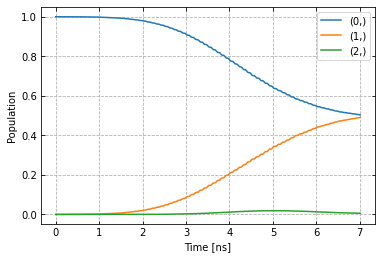

In [54]:
plot_dynamics(exp, init_state, barely_a_seq)

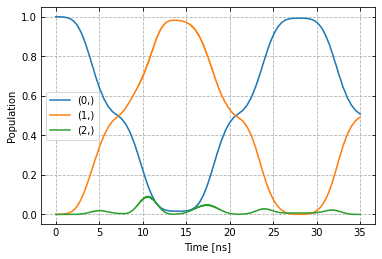

In [55]:
plot_dynamics(exp, init_state, barely_a_seq * 5)

We can also display the optimal parameters:

In [56]:
parameter_map.print_parameters()    # meta_param = 10^-4

rx90p[0]-d1-gauss-amp                 : 359.745 mV 
rx90p[0]-d1-gauss-freq_offset         : -52.999 MHz 2pi 
rx90p[0]-d1-gauss-xy_angle            : 238.731 mrad 
rx90p[0]-d1-gauss-delta               : -1.000  
rx90p[0]-d1-carrier-framechange       : 391.967 mrad 
rx90p[0]-d1-gauss2-amp                : 326.312 mV 
rx90p[0]-d1-gauss2-freq_offset        : -52.999 MHz 2pi 
rx90p[0]-d1-gauss2-xy_angle           : 220.908 mrad 
rx90p[0]-d1-gauss2-delta              : -1.000  
rx90p[0]-d1-gauss3-amp                : 289.937 mV 
rx90p[0]-d1-gauss3-freq_offset        : -52.999 MHz 2pi 
rx90p[0]-d1-gauss3-xy_angle           : 203.013 mrad 
rx90p[0]-d1-gauss3-delta              : -1.000  
rx90p[0]-d1-gauss4-amp                : 249.585 mV 
rx90p[0]-d1-gauss4-freq_offset        : -52.999 MHz 2pi 
rx90p[0]-d1-gauss4-xy_angle           : 185.031 mrad 
rx90p[0]-d1-gauss4-delta              : -1.000  
rx90p[0]-d1-gauss5-amp                : 147.543 mV 
rx90p[0]-d1-gauss5-freq_offset        : -52.99

In [57]:
# pre_factor = [0.000335, 0.393302, 0.000335, 0.000335, 0.393302, 0.393302, 0.393302]
# plot_controls(parameter_map, pre_factor)

In [58]:
c3_job_opt = c3_backend.run(qc)
result_opt = c3_job_opt.result()
res_pops_opt = result_opt.data()["state_pops"]
print("Result from optimized gates:")
pprint(res_pops_opt)

No classical registers in circuit "circuit-0", counts will be empty.


Result from optimized gates:
{'(0,)': 0.503405530663898,
 '(1,)': 0.4906842786662284,
 '(2,)': 0.005910190669890208}


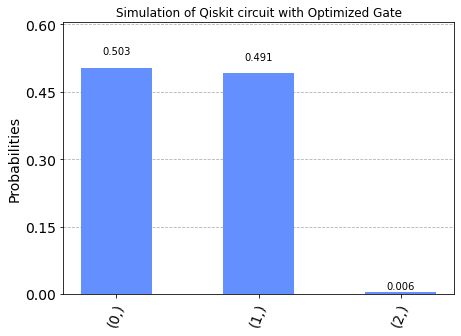

In [59]:
plot_histogram(res_pops_opt, title='Simulation of Qiskit circuit with Optimized Gate')

In [60]:
rx90p_q1.comps["d1"]

{'gauss': gauss:: amp : 359.745 mV , delta : -1.000  , freq_offset : -52.999 MHz 2pi , xy_angle : 238.731 mrad , sigma : 1.750 ns , t_final : 7.000 ns , shape: gaussian_nonorm, drag pulseFalse, ,
 'carrier': carrier:: freq : 5.050 GHz 2pi , framechange : 391.967 mrad , ,
 'gauss2': gauss2:: amp : 326.312 mV , delta : -1.000  , freq_offset : -52.999 MHz 2pi , xy_angle : 220.908 mrad , sigma : 1.750 ns , t_final : 7.000 ns , shape: gaussian_nonorm, drag pulseFalse, ,
 'gauss3': gauss3:: amp : 289.937 mV , delta : -1.000  , freq_offset : -52.999 MHz 2pi , xy_angle : 203.013 mrad , sigma : 1.750 ns , t_final : 7.000 ns , shape: gaussian_nonorm, drag pulseFalse, ,
 'gauss4': gauss4:: amp : 249.585 mV , delta : -1.000  , freq_offset : -52.999 MHz 2pi , xy_angle : 185.031 mrad , sigma : 1.750 ns , t_final : 7.000 ns , shape: gaussian_nonorm, drag pulseFalse, ,
 'gauss5': gauss5:: amp : 147.543 mV , delta : -1.000  , freq_offset : -52.999 MHz 2pi , xy_angle : 148.713 mrad , sigma : 1.750 ns , 